# Introduction / Review of basic Digital Image Processing in Python (using OpenCV and numpy)

The **goal** of this practice session is to get familiarized with python and standard scientific computing packages used for computer vision (such as [OpenCV](https://opencv.org/) and [numpy](https://numpy.org/)) in the context of performing basic image processing operations, such as filtering.

If you already know these tools, you can skip this session. Its intention is that all of us in class are "on the same page" for the next exercises.

# Python

Since we will use ROS ([Robot Operating System](https://www.ros.org/) - Kinetic or Melodic versions) and it is starting to transition toward using Python 3 in its [Noetic](http://wiki.ros.org/UsingPython3) version, we review here using Python 2.7. Feel free to adapt the code to Python 3 if you want (and let your colleagues in class know about it).

Hence, we use Python 2.7 and numpy, opencv2 packages in Linux (e.g., Ubuntu LTS).

There are several ways to install these. 

- Installation of numpy using pip: `sudo apt update; sudo apt install python-pip; pip install numpy`
- Installation of opencv using pip: `pip install opencv-python`

See [opencv-python](ttps://pypi.org/project/opencv-python/)

You may also install OpenCV using a package manager, such as `Synaptic Package Manager`.
 

**ROS**: Another possible way to install OpenCV that will be useful for future sessions is to get it from ROS. The [Desktop Install version of ROS](http://wiki.ros.org/kinetic/Installation/Ubuntu) should suffice. Both versions, ROS Kinetic (2016) or ROS Melodic (2018), should work. Example installation command: `sudo apt-get install ros-kinetic-desktop`

In your own time, feel free to go beyond the exercises in this session. You may follow a basic tutorial in python and numpy to know how to create variables and how to access their content. You may follow OpenCV tutorials to play around with image data.

## Script

For this exercise we use the Python code in the script `ex1_improc.py` 

The script is incomplete. The parts marked with `???` need to be completed for proper execution.

With the script we aim to learn the following:
- How to load an image an image from disk
- How to write an image to disk (image which may include negative values)
- How to plot image without visual artefacts
- What the spatial and intensity resolutions of an image are
- How to linearly filter an image with a kernel
- How to compute derivatives of image data
  - In space, within an image (Sobel operators)
  - In time, using two images (forward difference formula)

# Basics of Digital Image Processing

A classic reference on Digital Image Processing is the book by Gonzalez and Woods, ["Digital Image
Processing"](http://www.imageprocessingplace.com/DIP-4E/dip4e_main_page.htm), now in its 4th edition (2018), which contains MATLAB code. The same authors also have a more practical book called "Digital Image Processing Using MATLAB" (3rd edition). These are just some references in case you want to read more about image processing.

## Digital Images
Monochrome (grayscale) images can be modeled by two-dimensional functions $f:\mathbb{R}^{2}\to\mathbb{R}$. The amplitude of $f$ at spatial coordinates $(x,y)$, i.e., $f(x,y)$, is called the *intensity* or \emph{gray level} at that point, and it is related to a physical quantity by the nature of the image acquisition device; for example, it may represent the energy radiated by a physical source. We will deal with bounded (i.e., finite) quantities, and so $|f|<\infty$. Common practice is to perform an affine transformation (substituting $f\leftarrow af+b$ for all $(x,y)$ by means of some suitable constants $a,b$) so that $f$ takes values in a specified interval, e.g., $f\in[0,1]$.

**A digital image** can be modeled as obtained from a continuous image $f$ by a conversion process having two steps: sampling (digitizing the spatial coordinates $x,y$) and quantization (digitizing the amplitude $f$). Therefore, a digital image may be represented by an array of numbers, $M=(m_{ij}),$ where $i,j$ and $m$ can only take a finite number of values, e.g., $i=\{0,1,\ldots,W-1\}$, $j=\{0,1,\ldots,H-1\}$ and $m=\{0,1,\ldots,L-1\}$ for some positive integers $W,H,L$ (Width, Height and number of gray Levels). That is, a digital image is a 2-D function whose coordinates and amplitude values are discrete (e.g., integers). Specifically,  $$m_{ij}=q\bigl(f(x,y)\bigr)=q\bigl(f(x_{0}+i\cdot\Delta x,\,y_{0}+j\cdot\Delta y)\bigr),$$
where $\Delta x$ and $\Delta y$ are the sampling steps in a grid with spatial coordinates starting at some location $(x_{0},y_{0})$, and $q:\mathbb{R}\to\{0,\ldots,L-1\}$ is the input-output function of the quantizer (which has a staircase shape).

Common practice for grayscale images is to use 1 byte to represent the intensity at each location $(i,j)$ (i.e., picture element or "pixel"). Since 1 byte = 8 bits, the number of possible gray levels is $L=2^{8}=256$, and so intensities range from $i=0$ (black) to $i=L-1=255$ (white). Hence, images are typical stored and read as unsigned character (unsined int8 variables). However, to numerically operate with grayscale images, it is convenient to convert the data type of the image values from integers to real numbers, i.e., from 8 bits to single or double precision (float type). Once operations are finished, it may be convenient to convert back to 8 bit format for storage of the resulting image, thus producing a quantization of the data values. Medical images are usually represented with a larger depth (10-12 bits) to mitigate the occurrence of visual artifacts due to the quantization process.

Color images can be represented, according to the human visual system, by the combination of three monochrome images (with the amount of red (R), green (G) and blue (B) present in the image), and so, each pixel is represented by 3 bytes, which provides a means to describe $2^{3\times8}\approx16.8$ million different colors. Many of the techniques developed for monochrome images can be extended to color images by processing the three component images individually.

The number of bits required to store a (grayscale) digital image is $b=W \cdot H \cdot \log_{2}(L)$, and so compression algorithms (such as JPEG) are essential to reduce the storage requirement by exploiting and removing redundancy of the image.

**Spatial resolution** is a measure of the smallest discernible detail in an image, and it is usually given in dots (pixels) per unit distance. That is, it is the density of pixels over the image, but informally, the image size ($W\times H$ pixels) is regarded as a measure of spatial resolution (although it should be stated with respect to physical units - cm, etc.). It is common to refer to the number of bits used to quantize intensity as the **intensity resolution**.

Let us show how to load an image, such as ![Tiger](images/tigerg.jpg)
Standard images can be downloaded from [standard_test_images.zip](http://www.imageprocessingplace.com/downloads_V3/root_downloads/image_databases/standard_test_images.zip)

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

Some auxiliary functions

In [3]:
""" Function to save an image with positive and negative values to disk
mapping the zero values to the middle gray level (about level 128 in [0,255])
  - maxabsval: maximum absolute value of input image src
"""
def imwriteSymmetricImage(filename, src, maxabsval=None):
    
    if not maxabsval:
        maxabsval = np.amax(np.abs(src))
       
    # Conversion form the interval [-1,1]*maxabsval to [0,255]
    #   the value -maxabsval maps to 0
    #   the value  maxabsval maps to 255
    img_normalized = (src + maxabsval)*(255/(2*maxabsval))
    cv2.imwrite(filename, img_normalized)

In [4]:
""" Function to plot without artefacts.
By default, imshow on my notebook produces image aliasing (https://en.wikipedia.org/wiki/Aliasing)
So this function tries to mitigate that effect in the jupyter notebook, displaying at the actual iamge size
"""
def myimshow(src):
    dpi = 80
    h, w = src.shape
    fig = plt.figure(figsize=(h/float(dpi), w/float(dpi)), dpi=dpi)
    ax = fig.add_axes([0,0,1,1])
    ax.imshow(src, extent=(0,w,h,0), interpolation=None, cmap='gray')
    ax.set_xticks([])  # remove xticks
    ax.set_yticks([])  # remove yticks
    ax.axis('off')

### Load image from disk
To read an image from disk, we use the OpenCV command `imread`:

In [ ]:
img = cv2.imread('images/barbara.png', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('images/tigerg.jpg', cv2.IMREAD_GRAYSCALE)

It will return a variable called `img` of type uint8 (unsigned integer represented by 8 bits = 1 byte) and it is a multi-dimensional array/matrix of size $N_{\text{rows}}\times N_{\text{cols}}\times N_{\text{channels}}$. 
If $N_{\text{channels}}=3$ there are three channels or "bands", thus, it is a color image (typically in RGB format). In the additional arguments of the function we indicate to read as grayscale image, so it only has one channel.

We may check the type of the variables as follows:

In [ ]:
print(type(img))  # numpy ndarray
print(img.dtype)  # unit8 or float64

We can get the size of the image by using the command

In [ ]:
height, width = img.shape

There are different ways of printing values on screen:

In [ ]:
print img.shape
print height, width
print("height=",height," width=",width)
print("height= {}, width={}".format(height, width))

Let us convert to floating point values (for numerical manipulation), so that we are not restricted to operations with only 8 bits (256 representation levels):

In [ ]:
img = img.astype(float)

We may check again:

In [ ]:
print(type(img))  # numpy ndarray
print(img.dtype)  # unit8 or float64

### Displaying an image. Coordinate axes convention

To visualize the image that has been previously loaded in variable img, you may use [matplotlib.pyplot's](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.html) commands imshow or figimage. 
The default options of the command imshow causes some artefacts (e.g., [moire patterns](https://en.wikipedia.org/wiki/Moir%C3%A9_pattern) by resizing the image, so we use the command figimage instead.
In this jupiter notebook, we defined the function `myimshow` to try to avoid the visualization artefacts.

In [ ]:
myimshow(img)

This creates a new window and display the image. By default, `imshow` or `figimage` do not use a grayscale colormap, so the image will be colored (even though it is supposed to be a grayscale image). Investigate the [documentation of figimage or imshow](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.figimage.html) to change the colormap from the default one to a grayscale one.

In images, the coordinate system origin is at the **upper left corner**, with the positive y axis extending downward (along the rows of the matrix variable img) and the positive x axis extending to the right (along the columns).

In [ ]:
plt.imshow(img, cmap='gray', interpolation=None)

### Selecting a Region of Interest (ROI) within an image

To select a subregion of an image (also called ROI - Region Of Interest) we may use Python [slice notation](https://stackoverflow.com/questions/509211/understanding-slice-notation). 
For example, to select the top-left $100\times200$-pixel region of `img` we type:

In [ ]:
img_sub = img[ 0:100, 0:200 ]
myimshow(img_sub)

Here is another example to select a central region of the image by cropping 20 pixels from the top and the bottom and 50 pixels from each side.

In [ ]:
# Using variables to specify the ROI (border cropping, in this case)
border_r = 20 # row dimension
border_c = 50 # column dimension
img_sub2 = img[ border_r:-border_r, border_c:-border_c ]
myimshow(img_sub2)

### Writing an image to disk
To save an image to disk, we use the OpenCV command `imwrite`:

In [ ]:
cv2.imwrite('SavedImage.png', img_sub2)

This will create a file called `SavedImage.png` in the working folder.

### Spatial resolution

Given a well-sampled digital image over a pixel grid, the effect of reducing the spatial resolution, i.e., the number of pixels (while keeping the number of intensity levels constant) is shown next.

The image quality degrades as it is represented with fewer number of pixels. The coarsening effect or "pixelization" is evident when an insufficient number of pixels is used; such number of samples cannot capture the fine details present in the scene.

You would need to know how to use the OpenCV command `cv2.resize` and the pyplot function `imshow` to complete the loop that generates the figure. The loop variable called scale\_factor indicates the value by which the original image is downsized (in each dimension, $x,y)$) to get each image in the figure.

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
for ax, k in zip(axs.flat, range(6)):
    scale_factor = 1./(2**k)
    img_small = cv2.resize(img, (0,0), fx=scale_factor, fy=scale_factor)
    ax.imshow(img_small, interpolation='none', cmap='gray')
    ax.set_title("Scale: 1 / " + str(2**k))
plt.tight_layout()

### Grayscale (range) resolution. 
Number of intensity levels, number of bits (bit depth). Artefacts

Next, we take a look at the effect of maintaining the spatial resolution but decreasing the intensity resolution. That is, we maintain the number of image pixels, but we use fewer bits to encode them.

For this part of the Python code, you would need to remember that division of integer-type variables produces integers and therefore discards fractional information, effectively producing a quantization effect. Feel free to use the following code or design simpler ways to generate a figure like the following one by processing the original image (in the top left of the figure).

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
for ax, k in zip(axs.flat, range(6)):
    size_quant_interval = 2**k
    img_quantized = (img.astype(int) / size_quant_interval) * size_quant_interval
    ax.imshow(img_quantized, interpolation='none', cmap='gray')
    ax.set_title("Num gray levels: " + str(256/size_quant_interval))
plt.tight_layout()

In the above figure... 
- Can you discern the differences between the resulting images?
- How many intensity levels does the human visual system need in order to represent the a natural scene faithfully? (You would need to test with multiple images).

Observe that, as the number of levels decreases, *false contours* appear in smooth intensity regions. In the bottom right image of the figure above, can you discern the 8 intensity levels used to represent the image?

It may be good to use the standard image called "Barbara" because it has both regions of smooth intensity variation (i.e., "low spatial frequencies"), such as the skin and the floor, and regions of large intensity variations ("high spatial frequencies"), such as edges and lines. It is good for testing purposes. Feel free to run the code on other images that have these two ingredients.

Which test image would you use to clearly see the number of reduced intensity levels?

In [ ]:
# Grayscale ramp image
x = np.arange(0, 255, 0.4)
y = np.arange(0, 255, 0.666)
xx, yy = np.meshgrid(x, y)
img_ramp = xx
myimshow(img_ramp)

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
for ax, k in zip(axs.flat, range(6)):
    size_quant_interval = 2**k
    img_quantized = (img_ramp.astype(int) / size_quant_interval) * size_quant_interval
    ax.imshow(img_quantized, interpolation='none', cmap='gray')
    ax.set_title("Num gray levels: " + str(256/size_quant_interval))
plt.tight_layout()

## Filtering (convolution)

### 1-D (Linear) Filtering. Convolution

The convolution of two sequences of numbers ("signals") $a[n]$ and $b[n]$, $n\in\mathbb{Z}$, is symbolized by $c=a\star b$ and calculated according to
$$c[n]=\sum_{k=-\infty}^{\infty}a[k]b[n-k].\label{eq:convolutionDef}$$
The convolution is commutative ($a\star b=b\star a$), so $a$ and $b$ can be swapped in the previous formula. In practice, we use sequences of finite length, so the summation in previous formula  is carried over a finite number of products.

A demonstration of the convolution is illustrated in the movie [convolution.mp4](videos/convolution.mp4), where two signals $a,b$ are defined and their convolution is computed. 
In the video, one signal (middle plot, in blue) is multiplied by a reversed and shifted version (middle plot, red) of the other signal, and the sum of the product gives one sample of the output signal (bottom, in black).

Linear filtering is implemented by linear shift-invariant systems, whose output consists of the convolution of the input signal ($a$) and the impulse response of the filter ($b$), i.e., $c=a\star b$. For images, we will be using the 2-D convolution implemented in OpenCV's command [cv2.filter2D](https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#filter2d).


### 2-D (Linear) Filtering.

The convolution operation can be extend to two-dimensional discrete signals, i.e., monochrome images. The convolution of two digital images $h,f$ is written as $g=h\star f$ and calculated by 
$$g[i,j]=\sum_{u}\sum_{v}h[u,v]f[i-u,j-v].\label{eq:ConvTwoDimDef}$$

Often, $h$ is the filter (called "kernel" or "mask") and $f$ is the input image. Then, due to the commutativity of the convolution, $g=h\star f=f\star h$, it is standard to think of $g$ as computed by reversing and shifting $h$ (the kernel) rather than by reversing and shifting the input signal $f$ in the previous formula.

Each output pixel is computed by a weighted sum of its neighbors in
the input image, and if $h$ is a filter with a kernel of size $n\times n$
pixels, this is the size of the neighborhood, and it implies $n^{2}$
multiplications. For example, if $h$ is a filter with Gaussian shape
(samples of a Gaussian function on an $n\times n$ grid), each output
pixel is computed as a Gaussian weighted average of the input pixels
in the neighborhood. The output $g$ will be smoother than the input
$f$ since high frequencies have been attenuated by the filter $h$.
You could see this by plotting the Fourier Transform of $h$, but
this is optional for you to show.

*Separable filters* are of special importance since they save a lot
of computations. A filter is separable if its kernel can be written
as the product of two independent 1-D kernels, i.e., $h[u,v]=p[u]q[v]$.
That is, the matrix $h[u,v]$ can be written as the (exterior) product
of two vectors $p[u]$ and $q[v]$. This reduces the cost of convolution;
the filtered image can be obtained as a cascade of the two 1-D convolutions,
with $2n$ multiplications per pixel instead of the $n^{2}$ count
in the general, non-separable case. This is internally handled by
OpenCV in popular filters, and there is a specific function for that
in case you are curious about it: [cv2.sepFilter2D](https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#sepfilter2d).

### Box filter
Let us use a 5x5 kernel size that will sum all the values in the image and then divide by 25, that is, that will average all the intensity values in the image as the kernel sweeps through it.

In [ ]:
# kernel of 5x5 size
# kernel = np.ones((5,5),np.float32)/25
# img_box = cv2.filter2D(img,-1,kernel)
img_box = cv2.blur(img, (5,5))

Let us now display the original and the filtered images:

In [ ]:
myimshow(img)
myimshow(img_box)

### Smoothing by Gaussian filtering

In [ ]:
s = 2. # Parameter that controls the amount of smoothing
if s > 0:
    img_gauss = cv2.GaussianBlur(img, (0,0), sigmaX = s, sigmaY = s)

myimshow(img_gauss)

### Noise filtering
### Additive Gaussian noise

In [ ]:
# Create Gaussian Noise (of the same size as the image)
img_noise = 0*img
cv2.randn(img_noise,(0),(15))
myimshow(img_noise)

In [ ]:
# Add noise to the clean image to obtain a noisy image that we want to filter
img_corrupted = img + img_noise
# (we use floats instead of 8-bit numbers to represent intensity levels)
myimshow(img_corrupted)

In [ ]:
# Filter image using a linear filter
s = 1.5 # Parameter that controls the amount of smoothing
img_filtered = cv2.GaussianBlur(img_corrupted, (0,0), sigmaX = s, sigmaY = s)
myimshow(img_filtered)

### Salt-and-pepper noise

In [ ]:
# Add salt-and-pepper noise
img_noise = 0*img
cv2.randu(img_noise,(0),(1))
img_corrupted = img.copy() # create a copy
img_corrupted[img_noise < .03] = 0.
img_corrupted[img_noise > 0.97] = 255.
myimshow(img_corrupted)

In [ ]:
# Fitler the image using a linear filter
img_filtered = cv2.GaussianBlur(img_corrupted, (0,0), sigmaX = s, sigmaY = s)
myimshow(img_filtered)

In [ ]:
# Fitler the image using a median filter (it is a non-linear filter)
# For the median filter in OpenCV the input cannot be float
img_corrupted_8bits = cv2.convertScaleAbs(img_corrupted)
img_median = cv2.medianBlur(img_corrupted_8bits,3)
myimshow(img_median)

- Which of the two above filters (Gaussian, median) works better against salt-and-pepper noise? The median filter, because it throws away the value of the corrupted pixel; it does not average it with its neighbors.
- Which one works better against zero-mean additive Gaussian noise? The linear Gaussian filter (convolution). One can show mathematically that the Gaussian filter is the optimal solver for Gaussian noise.
- Why?

### Spatial derivatives. Sobel operator

In [6]:
grad_x = cv2.Sobel(img, cv2.CV_64F, 1,0)
grad_y = cv2.Sobel(img, cv2.CV_64F, 0,1)

myimshow(grad_x)  # Image gradient x
myimshow(grad_y)  # Image gradient y

NameError: name 'img' is not defined

In [ ]:
# %% Plot the filter mask or signal or kernel used
ksize = 5  # Size of the impulse image
impulse_img = np.zeros((ksize,ksize))
impulse_img[ksize/2,ksize/2] = 1
sobel_response_to_impulse = cv2.Sobel(impulse_img, cv2.CV_64F, 1,0)
print sobel_response_to_impulse

In [ ]:
# Need to scale the gradient appropriately so that they have meaning of derivative
grad_x /= 8
grad_y /= 8

In [ ]:
# %% Write derivative images to disk

# Plot histogram
fig = plt.figure()
plt.hist(grad_x.ravel(), bins=101)
plt.title('Histogram of grad_x')
plt.show()

Before writing to disk (using unsigned 8 bits), we need to convert the range of the derivative images, from $[-b,b]$ to $[0,255]$. To compute the min and max of the image, check out the documenation of the OpenCV function [cv2.minMaxLoc](https://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html#minmaxloc).

In [ ]:
# Convert from (-b,b) to (0,255)
#min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(grad_x)
min_valx, max_valx, _, _ = cv2.minMaxLoc(grad_x)
min_valy, max_valy, _, _ = cv2.minMaxLoc(grad_y)
M_val = np.amax([np.abs(min_valx), max_valx, np.abs(min_valy), max_valy])
print M_val
imwriteSymmetricImage('grad_x.png', grad_x, M_val)
imwriteSymmetricImage('grad_y.png', grad_y, M_val)

In [ ]:
# %% Convert gradient (x,y) to magnitude and phase
grad_mag, grad_dir = cv2.cartToPolar(grad_x, grad_y)

# Alternative commands
#grad_mag = np.hypot(grad_x, grad_y) 
#grad_dir = np.arctan2(grad_y,grad_x)

myimshow(grad_mag)  # Gradient magnitude
myimshow(grad_dir)  # Gradient direction

cv2.imwrite('grad_mag.png', grad_mag * 255 / np.amax(grad_mag))
imwriteSymmetricImage('grad_dir.png', grad_dir)

### Temporal derivative

In [ ]:
# DOWNLOAD slider_depth sequence (txt format) from DAVIS dataset
import wget
print('Beginning file download with wget...')
url = 'http://rpg.ifi.uzh.ch/datasets/davis/slider_depth.zip'
wget.download(url, 'slider_depth.zip')

After downloading the dataset, **unzip it**.

180 240
442.0


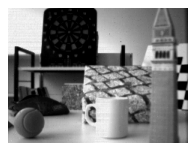

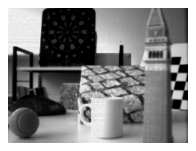

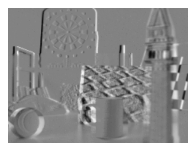

In [5]:
# Load images
id0 = 59
filename_prefix = 'slider_depth/images/frame_'
filename_suffix = '.png'
filename1 = filename_prefix + ("%08d" % id0) + filename_suffix
filename2 = filename_prefix + ("%08d" % (id0+1)) + filename_suffix

# Which means:
#img1 = cv2.imread('/home/ggb/improc_py/slider_depth/images/frame_00000059.png', cv2.IMREAD_GRAYSCALE)
#img2 = cv2.imread('/home/ggb/improc_py/slider_depth/images/frame_00000060.png', cv2.IMREAD_GRAYSCALE)

# Read two consecutive images
img1 = cv2.imread(filename1, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(filename2, cv2.IMREAD_GRAYSCALE)
img1 = img1.astype(float)
img2 = img2.astype(float)
height, width = img1.shape
print (height, width)

# Compute the (approximation to the) temporal derivative
img_difference = img2 - img1

# Display two images and the temporal derivative
myimshow(img1)
myimshow(img2)
myimshow(img_difference)

# Saving images to disk using the same symmetric rage for all three derivatives
grad_x = cv2.Sobel(img2, cv2.CV_64F, 1,0)
grad_y = cv2.Sobel(img2, cv2.CV_64F, 0,1)
min_valx, max_valx, _, _ = cv2.minMaxLoc(grad_x)
min_valy, max_valy, _, _ = cv2.minMaxLoc(grad_y)
min_valt, max_valt, _, _ = cv2.minMaxLoc(img_difference)
M_val = np.amax([np.abs(min_valx), max_valx, np.abs(min_valy), max_valy, np.abs(min_valt), max_valt])
print (M_val)
imwriteSymmetricImage('grad_x.png', grad_x, M_val)
imwriteSymmetricImage('grad_y.png', grad_y, M_val)
imwriteSymmetricImage('grad_t.png', img_difference)

## Other topics to practice

The median and bilateral filters are popular non-linear filters in image processing. These do not follow a convolution formula.

**References**:
- [py_basic_ops](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_core/py_basic_ops/py_basic_ops.html)
- [py_filtering](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html#filtering)
- [OpenCV Smoothing Images](https://docs.opencv.org/2.4/doc/tutorials/imgproc/gausian_median_blur_bilateral_filter/gausian_median_blur_bilateral_filter.html)

In [ ]:
img8 = cv2.imread('images/tigerg.jpg', cv2.IMREAD_GRAYSCALE)
# For the median filter in OpenCV the input cannot be float
img_median = cv2.medianBlur(img8,7)
myimshow(img_median)

In [ ]:
img_blur = cv2.bilateralFilter(img8,7,75,75)
myimshow(img_blur)